# **IDL Project Assignment Task 3: Transfer Learning**

## **Assigning Tensorflow version and importing the libraries required for the tasks**


In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0'

In [2]:
os.getcwd()
os.chdir("/content/drive/My Drive/Colab Notebooks/IDL /IDL Project") 


## **Importing dataset**

**Importing MNIST dataset**

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

**Importing FMNIST Dataset**

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(ftrain_images, ftrain_labels), (ftest_images, ftest_labels) = fashion_mnist.load_data()

## **Task 3.1: Same distribution**

Split the MNIST dataset, such that 7 classes are the source domain and the other 3 classes are the target domain.
Start with the source domain data set and train a model on it.
From the trained model, cut off the final classification layer and replace it with a new layer for the target domain classes. For now, keep all layers trainable.
Now train this model on the target domain data set. For comparison, also train a freshly initialized model on the target domain data set.

How well did the transfer learning work, compared to training on the target data set from scratch?
You can e.g. compare:

*   achieved accuracy
*   steps until convergence
*   generalization





In [5]:
source_train_mask = np.isin(train_labels, [0,1,2,3,4,5,6])
target_train_mask = np.isin(train_labels, [7,8,9])

source_test_mask = np.isin(test_labels, [0,1,2,3,4,5,6])
target_test_mask = np.isin(test_labels, [7,8,9])

In [6]:
source_train_images, source_train_labels = train_images[source_train_mask], train_labels[source_train_mask]
target_train_images, target_train_labels = train_images[target_train_mask], train_labels[target_train_mask]


source_test_images, source_test_labels = test_images[source_test_mask], test_labels[source_test_mask]
target_test_images, target_test_labels = test_images[target_test_mask], test_labels[target_test_mask]


In [7]:
target_train_labels[target_train_labels==9] = 2
target_train_labels[target_train_labels==8] = 1
target_train_labels[target_train_labels==7] = 0

target_test_labels[target_test_labels==9] = 2
target_test_labels[target_test_labels==8] = 1
target_test_labels[target_test_labels==7] = 0

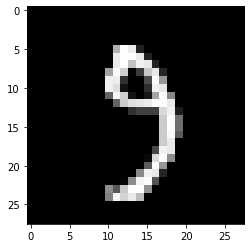

In [8]:
plt.imshow(target_test_images[455], cmap="Greys_r")

In [9]:
# this is now different
def batch_shuffle_repeat(train_images,train_labels,test_images,test_labels):    

    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

    test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # things we really gotta do:
    # - normalize the images to [0, 1] (first convert to float)
    # - reshape images from (28, 28) to (784,) (although we could do this later!)
    # - convert labels to int32 (otherwise tensorflow is gonna be sad :( )
    # (train_images.reshape([-1,28,28,1]).astype(np.float32)/255,train_labels.astype(np.int32)))
    train_images = (train_images.reshape([-1,28,28,1]).astype(np.float32)/255.)
    test_images = (test_images.reshape([-1,28,28,1]).astype(np.float32)/255.)

    train_labels = train_labels.astype(np.int32)
    test_labels = test_labels.astype(np.int32)

    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

    test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    
    train_data = train_data.shuffle(120000, reshuffle_each_iteration= True)
    train_data = train_data.batch(128) 

    test_data = test_data.batch(128)      

    return train_data,test_data

In [10]:
source_train_data, source_test_data = batch_shuffle_repeat(source_train_images,source_train_labels,source_test_images,source_test_labels)

target_train_data, target_test_data = batch_shuffle_repeat(target_train_images,target_train_labels,target_test_images,target_test_labels)

### **Source alone training**

In [11]:
source_model = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(7,use_bias= True,bias_initializer='zeros' )
                          ])

In [12]:
## Get the summary of the model
source_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 10983     
Total params: 24,231
Trainable params: 24,231
Non-trainable params: 0
____________________________________________________

In [13]:
source_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
source_history = source_model.fit(source_train_data,epochs= 20,validation_data=source_test_data)


Epoch 1/20
328/328 [==============================] - 3s 9ms/step - loss: 0.2460 - accuracy: 0.9247 - val_loss: 0.0520 - val_accuracy: 0.9838
Epoch 2/20
328/328 [==============================] - 3s 8ms/step - loss: 0.0477 - accuracy: 0.9853 - val_loss: 0.0303 - val_accuracy: 0.9900
Epoch 3/20
328/328 [==============================] - 3s 8ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0216 - val_accuracy: 0.9928
Epoch 4/20
328/328 [==============================] - 2s 7ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0242 - val_accuracy: 0.9918
Epoch 5/20
328/328 [==============================] - 2s 7ms/step - loss: 0.0204 - accuracy: 0.9935 - val_loss: 0.0202 - val_accuracy: 0.9928
Epoch 6/20
328/328 [==============================] - 2s 7ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0276 - val_accuracy: 0.9916
Epoch 7/20
328/328 [==============================] - 2s 7ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0174 - val_accuracy: 0.9938
Epoch 

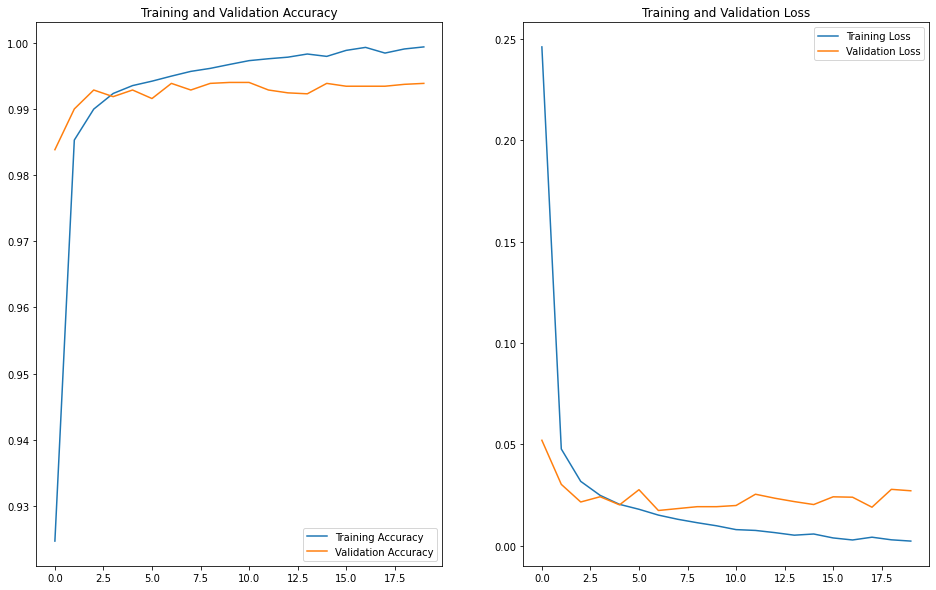

In [15]:
acc = source_history.history['accuracy']
val_acc = source_history.history['val_accuracy']

loss=source_history.history['loss']
val_loss=source_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Source to target transfer**

In [16]:
source_model_layers = source_model.layers

len(source_model_layers)

6

In [17]:
target_model = keras.Sequential()

In [18]:
for layer in range(0,len(source_model_layers)-1):
    target_model.add(source_model_layers[layer])

In [19]:
target_model.add(keras.layers.Dense(3,use_bias= True,bias_initializer='zeros' ))

In [20]:
target_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4707      
Total params: 17,955
Trainable params: 17,955
Non-trainable params: 0
__________________________________________________

In [21]:
target_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
target_history = target_model.fit(target_train_data,epochs= 20,validation_data=target_test_data)


Epoch 1/20
142/142 [==============================] - 1s 9ms/step - loss: 0.1622 - accuracy: 0.9408 - val_loss: 0.0343 - val_accuracy: 0.9884
Epoch 2/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0311 - accuracy: 0.9909 - val_loss: 0.0225 - val_accuracy: 0.9927
Epoch 3/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0162 - val_accuracy: 0.9960
Epoch 4/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0170 - accuracy: 0.9955 - val_loss: 0.0151 - val_accuracy: 0.9944
Epoch 5/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0141 - accuracy: 0.9962 - val_loss: 0.0128 - val_accuracy: 0.9960
Epoch 6/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.0142 - val_accuracy: 0.9954
Epoch 7/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.0148 - val_accuracy: 0.9947
Epoch 

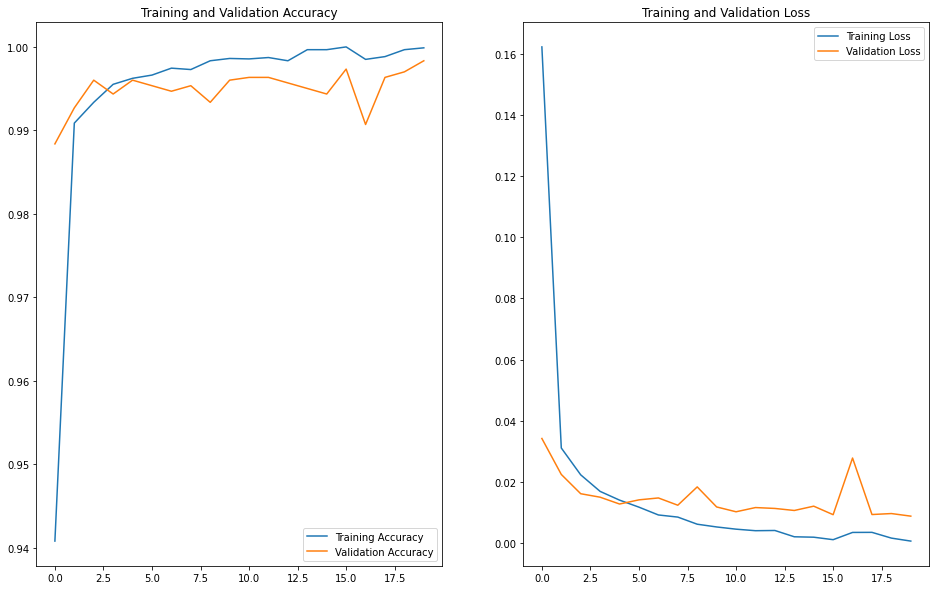

In [23]:
acc = target_history.history['accuracy']
val_acc = target_history.history['val_accuracy']

loss=target_history.history['loss']
val_loss=target_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Target domain alone training**

In [24]:
target_alone_model = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(3,use_bias= True,bias_initializer='zeros' )
                          ])

In [25]:
## Get the summary of the model
target_alone_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 4707      
Total params: 17,955
Trainable params: 17,955
Non-trainable params: 0
__________________________________________________

In [26]:
target_alone_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
target_alone_history = target_alone_model.fit(target_train_data,epochs= 20,validation_data=target_test_data)


Epoch 1/20
142/142 [==============================] - 1s 8ms/step - loss: 0.2731 - accuracy: 0.9149 - val_loss: 0.0799 - val_accuracy: 0.9728
Epoch 2/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0639 - accuracy: 0.9794 - val_loss: 0.0418 - val_accuracy: 0.9861
Epoch 3/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.0293 - val_accuracy: 0.9907
Epoch 4/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0325 - accuracy: 0.9904 - val_loss: 0.0220 - val_accuracy: 0.9924
Epoch 5/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.0189 - val_accuracy: 0.9917
Epoch 6/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0199 - val_accuracy: 0.9930
Epoch 7/20
142/142 [==============================] - 1s 7ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0151 - val_accuracy: 0.9950
Epoch 

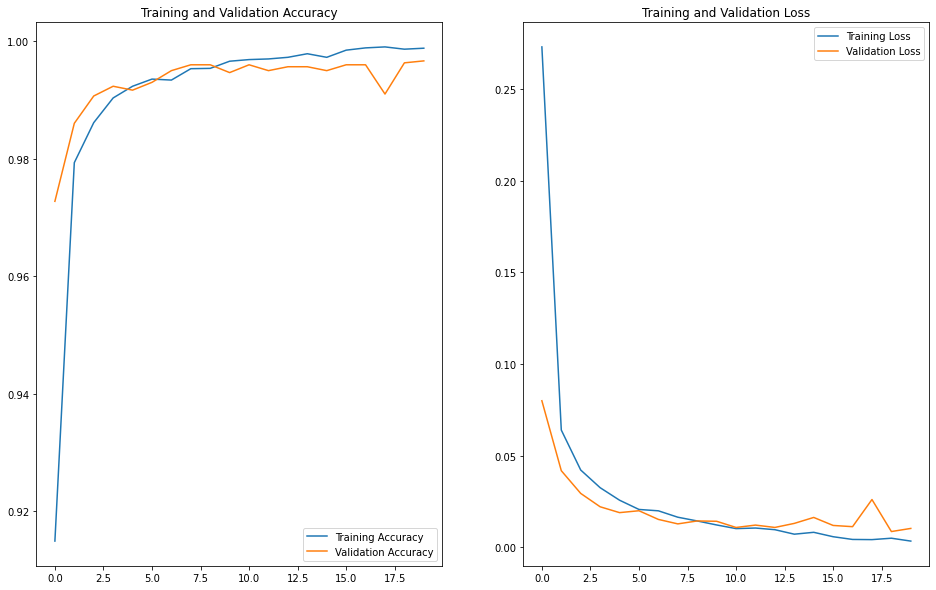

In [28]:
acc = target_alone_history.history['accuracy']
val_acc = target_alone_history.history['val_accuracy']

loss=target_alone_history.history['loss']
val_loss=target_alone_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

The data in consideration was of same distribution, split into two parts based on the labels. 

So transfer learning had same effect as the model trained from scratch for the target domain. Maybe it might have differences if data in different distribution is considered. 

## **Task 3.2: Different distribution**

Now we will work with MNIST as source domain and FMNIST as target domain. (This is convenient, as they already have the same input shape.)
Similar to 3.1, first train a model on the MNIST and use the pre-trained model as initialization for a model trained on FMNIST.
Compare this transfer learned model with a model trained on FMNIST from scratch using the measures from 3.1.

Repeat the experiment with FMNIST as source and MNIST as target!
Does transfer learning work better or worse this time?

In [29]:
mnist_train_data, mnist_test_data = batch_shuffle_repeat(train_images,train_labels,test_images,test_labels)

fmnist_train_data, fmnist_test_data = batch_shuffle_repeat(ftrain_images,ftrain_labels,ftest_images,ftest_labels)

### **MNIST as source and FMNIST as target**

#### **MNIST data train as source**

In [30]:
mnist_model = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [31]:
## Get the summary of the model
mnist_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [32]:
mnist_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
mnist_history = mnist_model.fit(mnist_train_data,epochs= 20,validation_data=mnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2932 - accuracy: 0.9174 - val_loss: 0.0942 - val_accuracy: 0.9710
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0800 - accuracy: 0.9758 - val_loss: 0.0643 - val_accuracy: 0.9801
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0580 - accuracy: 0.9825 - val_loss: 0.0503 - val_accuracy: 0.9834
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.0379 - val_accuracy: 0.9862
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 0.0355 - val_accuracy: 0.9883
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0386 - val_accuracy: 0.9884
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.0387 - val_accuracy: 0.9871
Epoch 

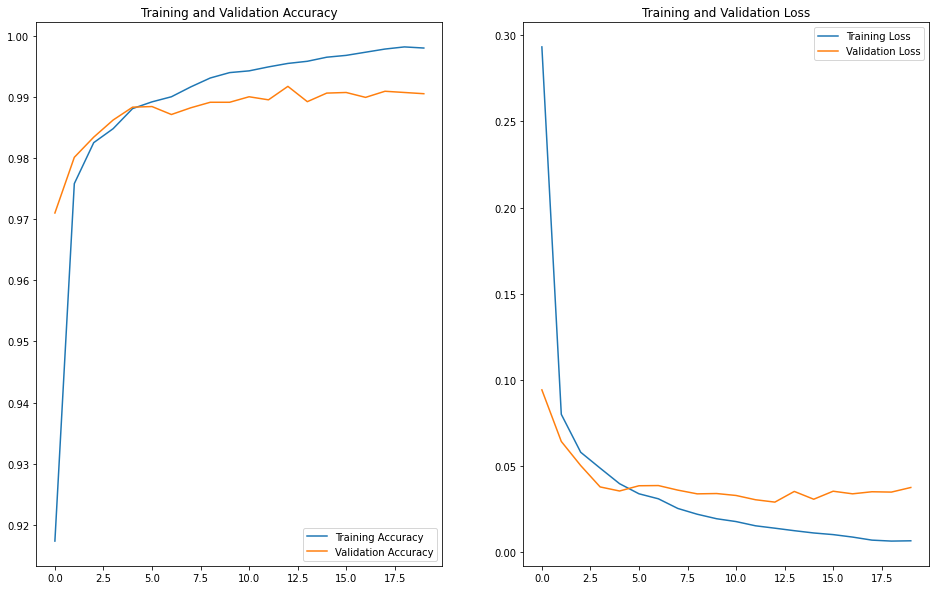

In [34]:
acc = mnist_history.history['accuracy']
val_acc = mnist_history.history['val_accuracy']

loss=mnist_history.history['loss']
val_loss=mnist_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **FMNIST data train as target by using pre-trained MNIST model**

In [35]:
mnist_model_weights = mnist_model.get_weights()

In [36]:
fmnist_model = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [37]:
fmnist_model.set_weights(mnist_model_weights)

In [38]:
## Get the summary of the model
fmnist_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [39]:
fmnist_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
fmnist_history = fmnist_model.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.7411 - accuracy: 0.7817 - val_loss: 0.4321 - val_accuracy: 0.8496
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3507 - accuracy: 0.8764 - val_loss: 0.3555 - val_accuracy: 0.8745
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.3044 - accuracy: 0.8917 - val_loss: 0.3317 - val_accuracy: 0.8802
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2764 - accuracy: 0.9011 - val_loss: 0.3092 - val_accuracy: 0.8894
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2562 - accuracy: 0.9080 - val_loss: 0.2906 - val_accuracy: 0.8954
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2393 - accuracy: 0.9139 - val_loss: 0.2912 - val_accuracy: 0.8947
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2274 - accuracy: 0.9180 - val_loss: 0.3120 - val_accuracy: 0.8864
Epoch 

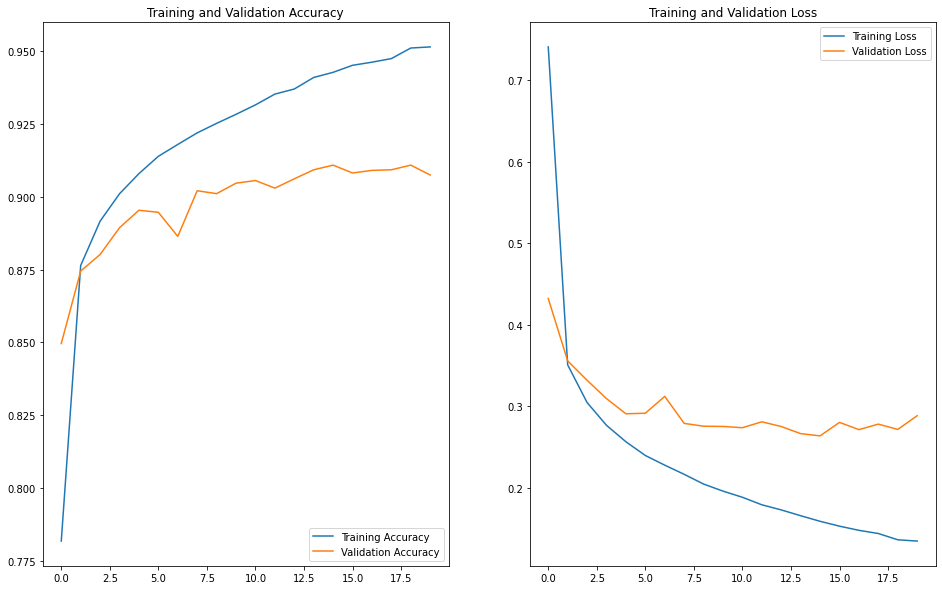

In [41]:
acc = fmnist_history.history['accuracy']
val_acc = fmnist_history.history['val_accuracy']

loss=fmnist_history.history['loss']
val_loss=fmnist_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **FMNIST data train from scratch**

In [42]:
fmnist_alone_model = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [43]:
## Get the summary of the model
fmnist_alone_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [44]:
fmnist_alone_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
fmnist_alone_history = fmnist_alone_model.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.6061 - accuracy: 0.7828 - val_loss: 0.4361 - val_accuracy: 0.8432
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3914 - accuracy: 0.8606 - val_loss: 0.3723 - val_accuracy: 0.8676
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3428 - accuracy: 0.8781 - val_loss: 0.3467 - val_accuracy: 0.8783
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3137 - accuracy: 0.8883 - val_loss: 0.3280 - val_accuracy: 0.8846
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2941 - accuracy: 0.8956 - val_loss: 0.3151 - val_accuracy: 0.8886
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2753 - accuracy: 0.9019 - val_loss: 0.3047 - val_accuracy: 0.8939
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2638 - accuracy: 0.9054 - val_loss: 0.2953 - val_accuracy: 0.8940
Epoch 

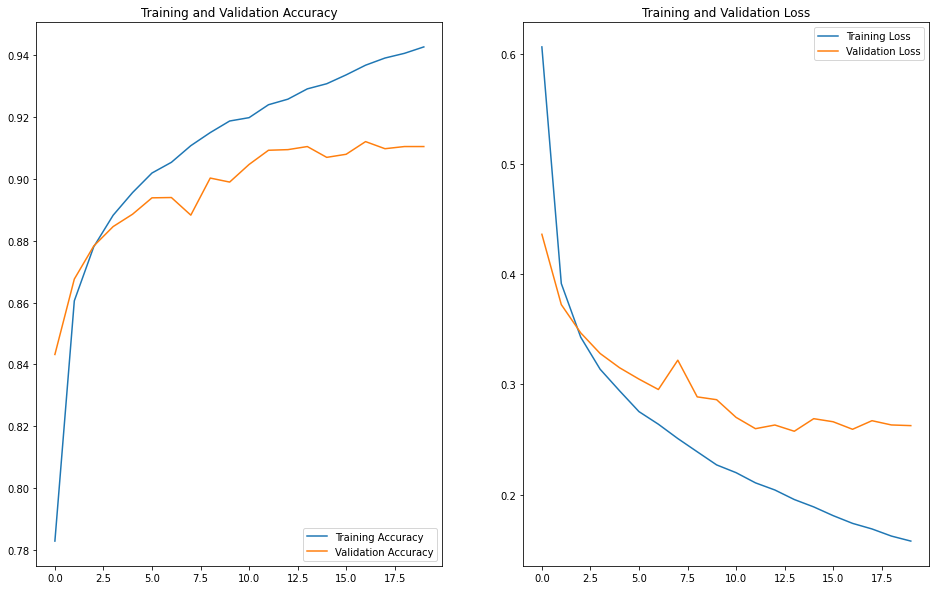

In [46]:
acc = fmnist_alone_history.history['accuracy']
val_acc = fmnist_alone_history.history['val_accuracy']

loss=fmnist_alone_history.history['loss']
val_loss=fmnist_alone_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

Transfer learning fared well compared to the data trained on FMNIST alone as a target data. This is earily interpreted using the accuracy and loss curves which are plotted. 

### **FMNIST as source and MNIST as target**

#### **FMNIST data train as source**

In [47]:
fmnist_model2 = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [48]:
## Get the summary of the model
fmnist_model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [49]:
fmnist_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
fmnist_history2 = fmnist_model2.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.6133 - accuracy: 0.7861 - val_loss: 0.4405 - val_accuracy: 0.8422
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3972 - accuracy: 0.8587 - val_loss: 0.3816 - val_accuracy: 0.8646
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3443 - accuracy: 0.8763 - val_loss: 0.3476 - val_accuracy: 0.8765
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3134 - accuracy: 0.8888 - val_loss: 0.3308 - val_accuracy: 0.8810
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2902 - accuracy: 0.8968 - val_loss: 0.3242 - val_accuracy: 0.8859
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2761 - accuracy: 0.9012 - val_loss: 0.2960 - val_accuracy: 0.8925
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2588 - accuracy: 0.9068 - val_loss: 0.2917 - val_accuracy: 0.8954
Epoch 

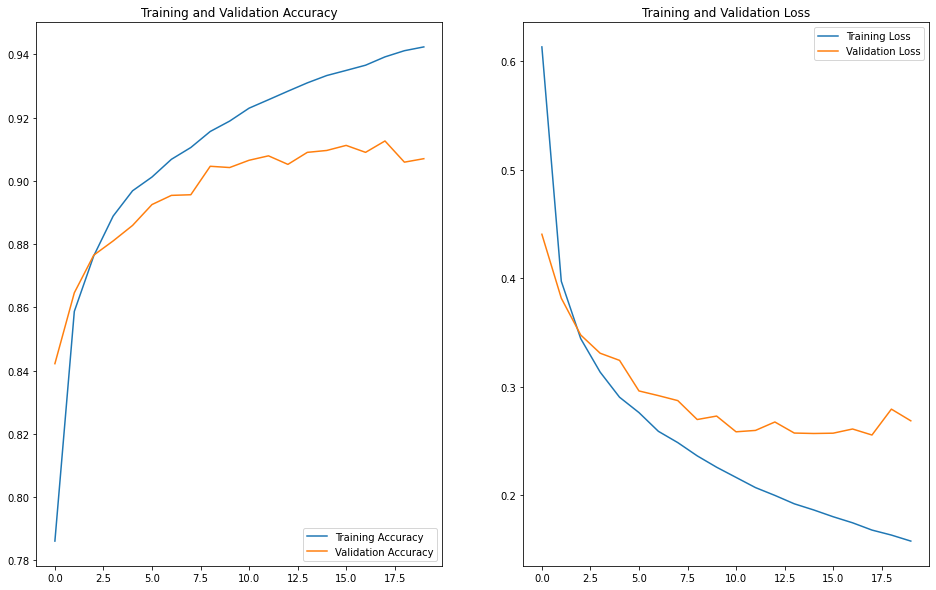

In [51]:
acc = fmnist_history2.history['accuracy']
val_acc = fmnist_history2.history['val_accuracy']

loss=fmnist_history2.history['loss']
val_loss=fmnist_history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **MNIST data train as target by using pre-trained FMNIST model**

In [52]:
fmnist_model2_weights = fmnist_model2.get_weights()

In [53]:
mnist_model2 = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [54]:
mnist_model2.set_weights(fmnist_model2_weights)

In [55]:
## Get the summary of the model
mnist_model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [56]:
mnist_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
mnist_history2 = mnist_model2.fit(mnist_train_data,epochs= 20,validation_data=mnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 9ms/step - loss: 0.5589 - accuracy: 0.8670 - val_loss: 0.1273 - val_accuracy: 0.9589
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0991 - accuracy: 0.9689 - val_loss: 0.0786 - val_accuracy: 0.9744
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0649 - accuracy: 0.9790 - val_loss: 0.0613 - val_accuracy: 0.9809
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0499 - accuracy: 0.9843 - val_loss: 0.0522 - val_accuracy: 0.9821
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0406 - accuracy: 0.9872 - val_loss: 0.0461 - val_accuracy: 0.9840
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0408 - val_accuracy: 0.9859
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0277 - accuracy: 0.9914 - val_loss: 0.0388 - val_accuracy: 0.9858
Epoch 

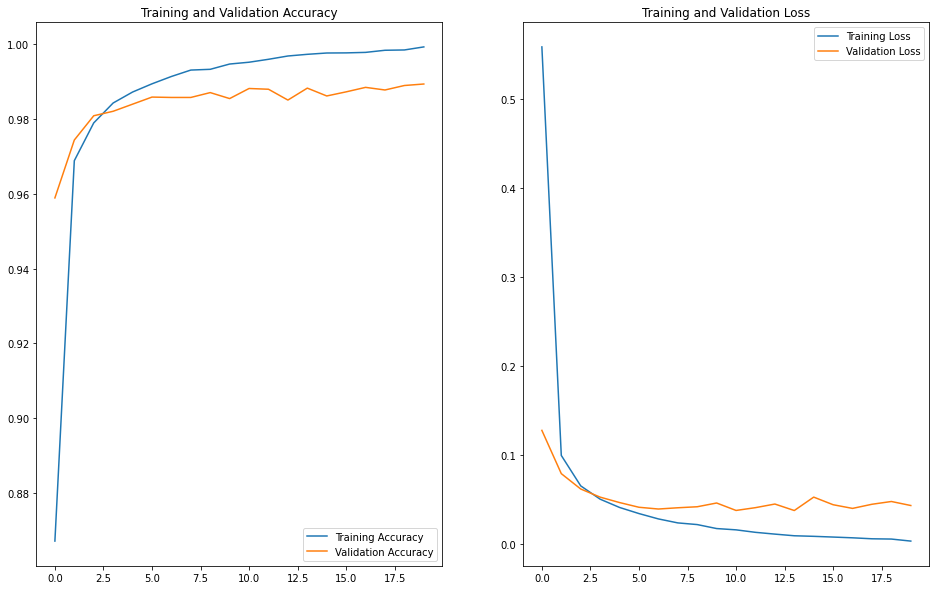

In [58]:
acc = mnist_history2.history['accuracy']
val_acc = mnist_history2.history['val_accuracy']

loss=mnist_history2.history['loss']
val_loss=mnist_history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **MNIST data train from scratch**

In [59]:
mnist_alone_model2 = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [60]:
## Get the summary of the model
mnist_alone_model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
__________________________________________________

In [61]:
mnist_alone_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
mnist_alone_history2 = mnist_alone_model2.fit(mnist_train_data,epochs= 20,validation_data=mnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2936 - accuracy: 0.9141 - val_loss: 0.0859 - val_accuracy: 0.9714
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0772 - accuracy: 0.9766 - val_loss: 0.0528 - val_accuracy: 0.9824
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0581 - accuracy: 0.9825 - val_loss: 0.0423 - val_accuracy: 0.9875
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.0343 - val_accuracy: 0.9884
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0342 - val_accuracy: 0.9892
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0292 - val_accuracy: 0.9897
Epoch 

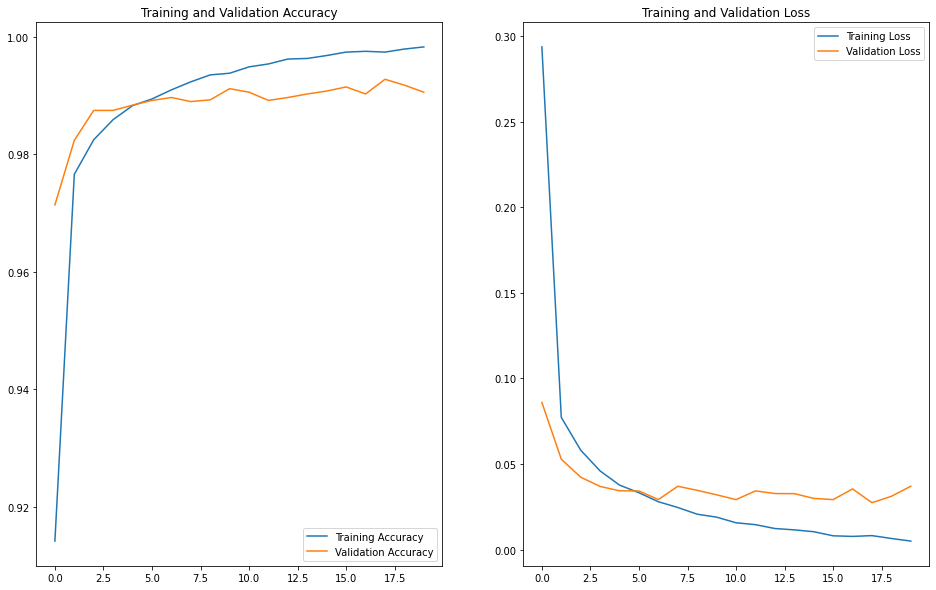

In [63]:
acc = mnist_alone_history2.history['accuracy']
val_acc = mnist_alone_history2.history['val_accuracy']

loss=mnist_alone_history2.history['loss']
val_loss=mnist_alone_history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

Transfer learning fared well compared to the data trained on MNIST alone as a target data. This is earily interpreted using the accuracy and loss curves which are plotted. 

This is due to the fact that data of different distributions were considered compared to task1 where data of same distribution was split and used. 

## **Task 3.3: Compare diffferent ways to do the transfer learning**

Transfer learning is done with different strategies.
You can for example investigate:

*  freezing all pre-trained layers (i.e. set trainable to False)
*  freezing only some bottom layers
*  replacing (or reinitializing) multiple top layers
*  replacing the source classification layer by multiple new ones for the target domain


This is particularly meaningful, if the target domain is more complex than the source domain.
Do you observe any differences in the final result using different ways of going from target to source?

### **Freezing all pretrained layers**

In [64]:
mnist_model_weights_task3a = mnist_model.get_weights()

In [65]:
fmnist_model_task3a = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [66]:
fmnist_model_task3a.set_weights(mnist_model_weights_task3a)

In [67]:
fmnist_model_task3a.trainable = False

In [68]:
## Get the summary of the model
fmnist_model_task3a.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                15690     
Total params: 28,938
Trainable params: 0
Non-trainable params: 28,938
__________________________________________________

In [69]:
fmnist_model_task3a.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
fmnist_history_task3a = fmnist_model_task3a.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 3s 6ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 2/20
469/469 [==============================] - 3s 5ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 3/20
469/469 [==============================] - 3s 5ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 4/20
469/469 [==============================] - 3s 5ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 5/20
469/469 [==============================] - 3s 5ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 9.4242 - accuracy: 0.1638 - val_loss: 9.4524 - val_accuracy: 0.1624
Epoch 

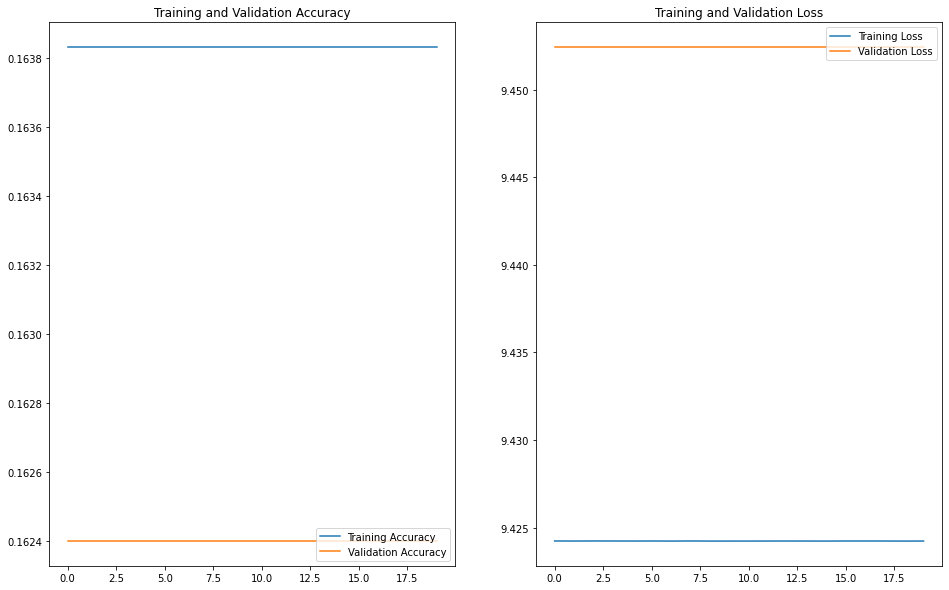

In [71]:
acc = fmnist_history_task3a.history['accuracy']
val_acc = fmnist_history_task3a.history['val_accuracy']

loss=fmnist_history_task3a.history['loss']
val_loss=fmnist_history_task3a.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Freezing only some bottom layers**

In [72]:
mnist_model_weights_task3b = mnist_model.get_weights()

In [73]:
fmnist_model_task3b = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [74]:
fmnist_model_task3b.set_weights(mnist_model_weights_task3b)

In [75]:
fmnist_model_task3b_layers = fmnist_model_task3b.layers

In [76]:
fmnist_model_task3b_layers[len(fmnist_model_task3b_layers)-1].trainable = False

In [77]:
## Get the summary of the model
fmnist_model_task3b.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                15690     
Total params: 28,938
Trainable params: 13,248
Non-trainable params: 15,690
____________________________________________

In [78]:
fmnist_model_task3b.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
fmnist_history_task3b = fmnist_model_task3b.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 9ms/step - loss: 1.2209 - accuracy: 0.6565 - val_loss: 0.6725 - val_accuracy: 0.7794
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.5640 - accuracy: 0.8109 - val_loss: 0.5440 - val_accuracy: 0.8179
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.4784 - accuracy: 0.8388 - val_loss: 0.4856 - val_accuracy: 0.8339
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 0.4279 - accuracy: 0.8559 - val_loss: 0.4468 - val_accuracy: 0.8468
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.3926 - accuracy: 0.8666 - val_loss: 0.4273 - val_accuracy: 0.8515
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.3696 - accuracy: 0.8730 - val_loss: 0.3996 - val_accuracy: 0.8627
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.3512 - accuracy: 0.8792 - val_loss: 0.3953 - val_accuracy: 0.8644
Epoch 

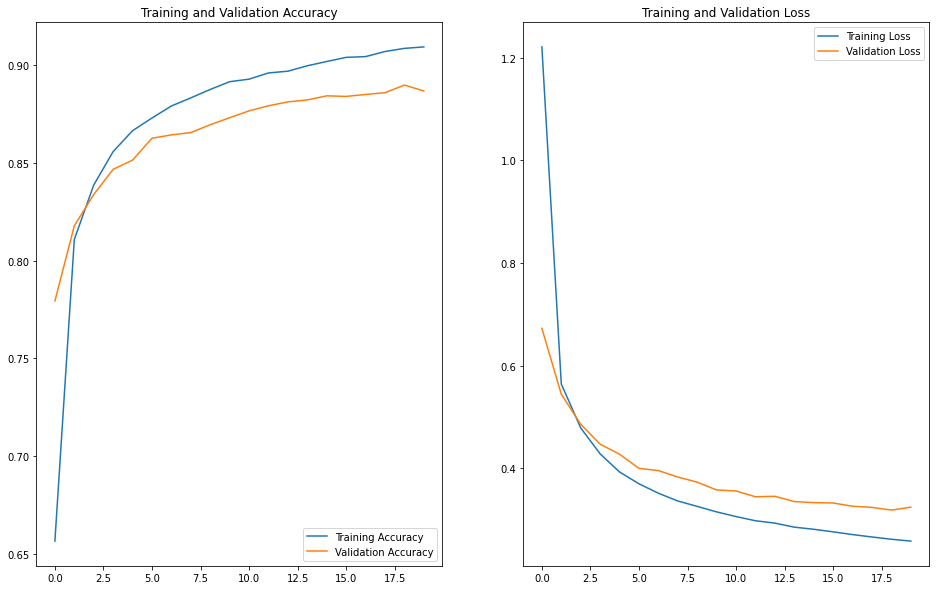

In [80]:
acc = fmnist_history_task3b.history['accuracy']
val_acc = fmnist_history_task3b.history['val_accuracy']

loss=fmnist_history_task3b.history['loss']
val_loss=fmnist_history_task3b.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Replacing (or reinitializing) multiple top layers**

In [81]:
mnist_model_weights_task3c = mnist_model.get_weights()

In [82]:
fmnist_model_task3c = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [83]:
fmnist_model_task3c.set_weights(mnist_model_weights_task3c)

In [84]:
## Get the summary of the model
fmnist_model_task3c.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
_________________________________________________

In [85]:
fmnist_model_task3c_layers = fmnist_model_task3c.layers

In [86]:
fmnist_model_task3c_new = keras.Sequential()

In [87]:
fmnist_model_task3c_new.add(keras.layers.Conv2D(filters= 16,kernel_size=[3,3],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)))
fmnist_model_task3c_new.add(keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'))


In [88]:
fmnist_model_task3c_new.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 16)        6416      
Total params: 6,576
Trainable params: 6,576
Non-trainable params: 0
_________________________________________________________________


In [89]:
for layer in range(1,len(fmnist_model_task3c_layers)):
    fmnist_model_task3c_new.add(fmnist_model_task3c_layers[layer])

In [90]:
fmnist_model_task3c_new.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 16)        6416      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)              

In [91]:
fmnist_model_task3c_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
fmnist_history_task3c = fmnist_model_task3c_new.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 5s 11ms/step - loss: 0.6087 - accuracy: 0.7772 - val_loss: 0.4108 - val_accuracy: 0.8567
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 0.3527 - accuracy: 0.8729 - val_loss: 0.3609 - val_accuracy: 0.8673
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.3072 - accuracy: 0.8876 - val_loss: 0.3237 - val_accuracy: 0.8774
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2791 - accuracy: 0.8993 - val_loss: 0.3064 - val_accuracy: 0.8888
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2589 - accuracy: 0.9049 - val_loss: 0.3034 - val_accuracy: 0.8919
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2441 - accuracy: 0.9114 - val_loss: 0.2732 - val_accuracy: 0.9029
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2303 - accuracy: 0.9166 - val_loss: 0.2688 - val_accuracy: 0.9006

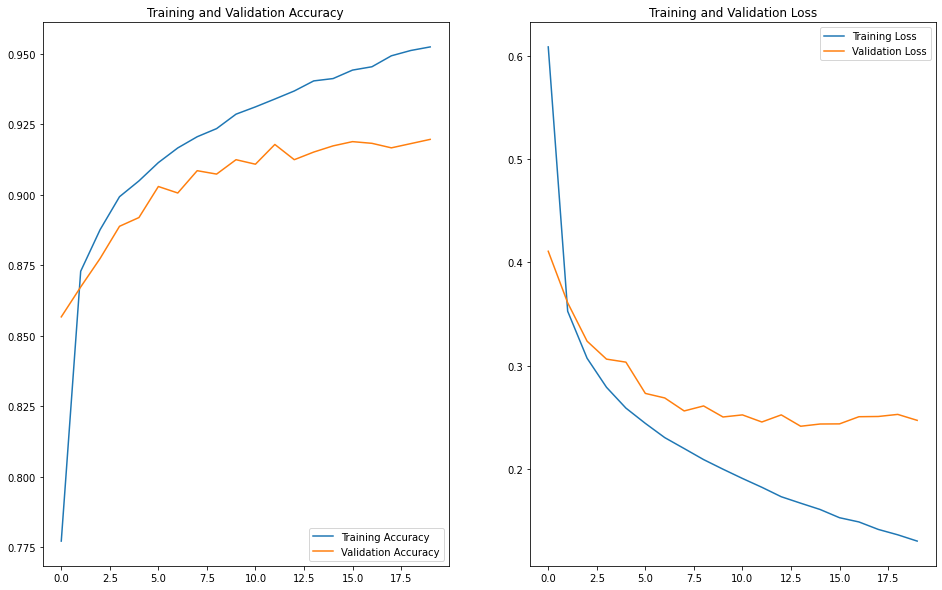

In [93]:
acc = fmnist_history_task3c.history['accuracy']
val_acc = fmnist_history_task3c.history['val_accuracy']

loss=fmnist_history_task3c.history['loss']
val_loss=fmnist_history_task3c.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Replacing the source classification layer by multiple new ones for the target domain**

In [94]:
mnist_model_weights_task3d = mnist_model.get_weights()

In [95]:
fmnist_model_task3d = keras.Sequential([keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ])

In [96]:
fmnist_model_task3d.set_weights(mnist_model_weights_task3d)

In [97]:
## Get the summary of the model
fmnist_model_task3d.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                15690     
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
_________________________________________________

In [98]:
fmnist_model_task3d_layers = fmnist_model_task3d.layers

In [99]:
fmnist_model_task3d_new = keras.Sequential()

In [100]:
for layer in range(0,len(fmnist_model_task3d_layers)-1):
    fmnist_model_task3d_new.add(fmnist_model_task3d_layers[layer])

In [101]:
fmnist_model_task3d_new.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
Total params: 13,248
Trainable params: 13,248
Non-trainable params: 0
_________________________________________________________________


In [102]:
fmnist_model_task3d_new.add(keras.layers.Dense(128,use_bias= True,bias_initializer='zeros' ))
fmnist_model_task3d_new.add(keras.layers.Dense(64,use_bias= True,bias_initializer='zeros' ))
fmnist_model_task3d_new.add(keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' ))


In [103]:
fmnist_model_task3d_new.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               200832    
_________________________________________________________________
dense_14 (Dense)             (None, 64)              

In [104]:
fmnist_model_task3d_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:
fmnist_history_task3d = fmnist_model_task3d_new.fit(fmnist_train_data,epochs= 20,validation_data=fmnist_test_data)


Epoch 1/20
469/469 [==============================] - 4s 9ms/step - loss: 0.4091 - accuracy: 0.8569 - val_loss: 0.3295 - val_accuracy: 0.8827
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2888 - accuracy: 0.8953 - val_loss: 0.3104 - val_accuracy: 0.8892
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2537 - accuracy: 0.9088 - val_loss: 0.2894 - val_accuracy: 0.8990
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2341 - accuracy: 0.9134 - val_loss: 0.2780 - val_accuracy: 0.9021
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2184 - accuracy: 0.9202 - val_loss: 0.2714 - val_accuracy: 0.9048
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.2025 - accuracy: 0.9256 - val_loss: 0.2896 - val_accuracy: 0.9017
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.1964 - accuracy: 0.9277 - val_loss: 0.2833 - val_accuracy: 0.9040
Epoch 

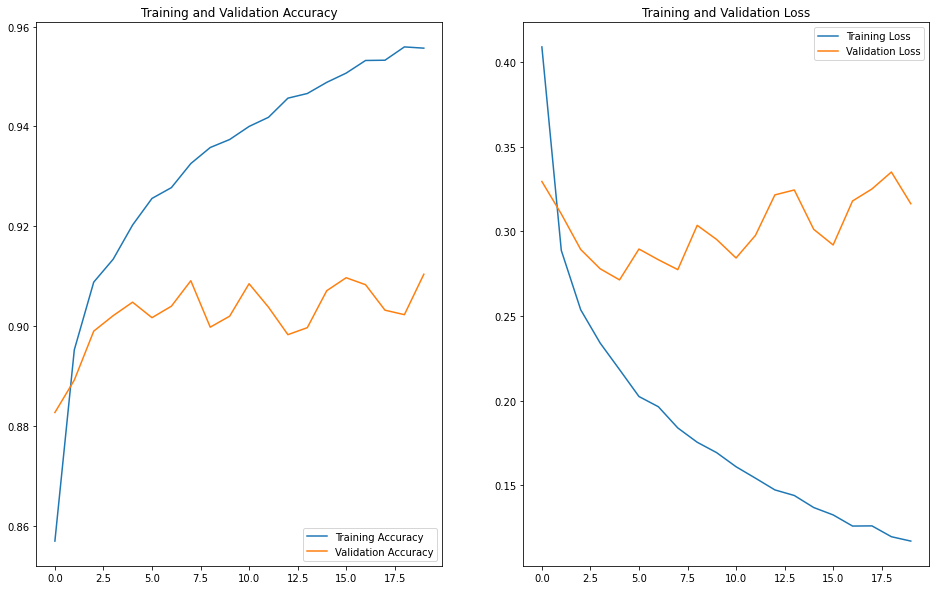

In [106]:
acc = fmnist_history_task3d.history['accuracy']
val_acc = fmnist_history_task3d.history['val_accuracy']

loss=fmnist_history_task3d.history['loss']
val_loss=fmnist_history_task3d.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Observations**

1. When freezing all the pre-trained layers, the model didn't perform good and the accuracy and loss were constant. So this isn't a recommended method of transfer learning. 

2. When freezing only the bottom layers, the model performed well, but it wasn't a perfect model. 

3. When replacing multiple top layers, the model performed better than the previous approach. 

4. Replacing the source classification layer by multiple layers yielded the best output characteristics in form of accuracy and losses. This is a suggestable method of transfer learning. 
